In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from prometheus_api_client import PrometheusConnect
# from sklearn.ensemble import IsolationForest
# import seaborn as sns
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.impute import SimpleImputer
from datetime import timedelta
from matplotlib import pyplot as plt


PROMETHEUS_URL = "http://localhost:9090"
end_time = datetime.now() 
# end_time = datetime(2025, 1, 24, 11, 30, 45)  # 24th Jan 2025 at 11:30:45
start_time = datetime(2025, 3, 15, 11, 30, 45)  # 24th Jan 2025 at 11:30:45
# start_time= datetime(2025, 1, 18, 8, 30, 45)
# end_time= datetime(2025, 1, 18, 20, 30, 45)
# start_time = end_time - timedelta(days=4)
# Ensure all rows are displayed
pd.set_option('display.max_rows', None)
# Initialize Prometheus connection
prom = PrometheusConnect(url=PROMETHEUS_URL, disable_ssl=True)


/home/henokbfg/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


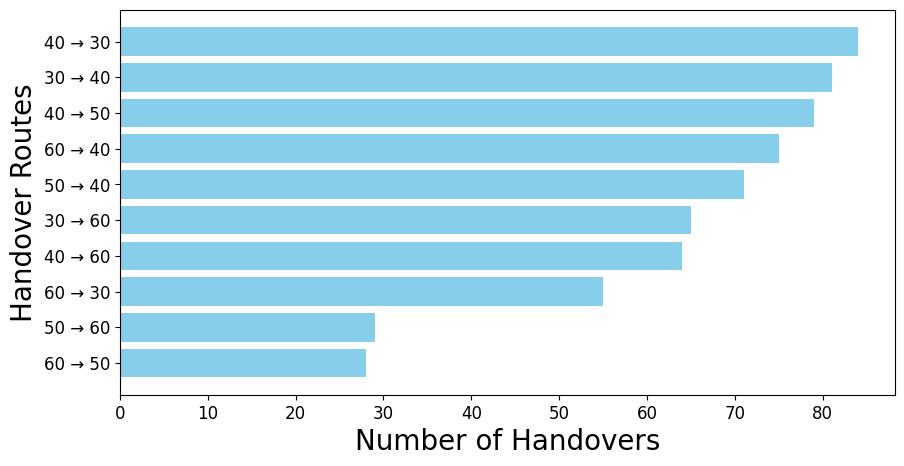

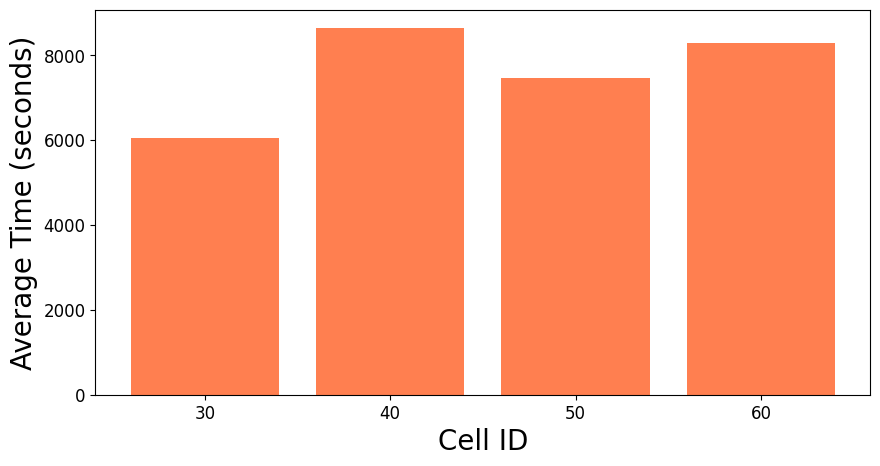

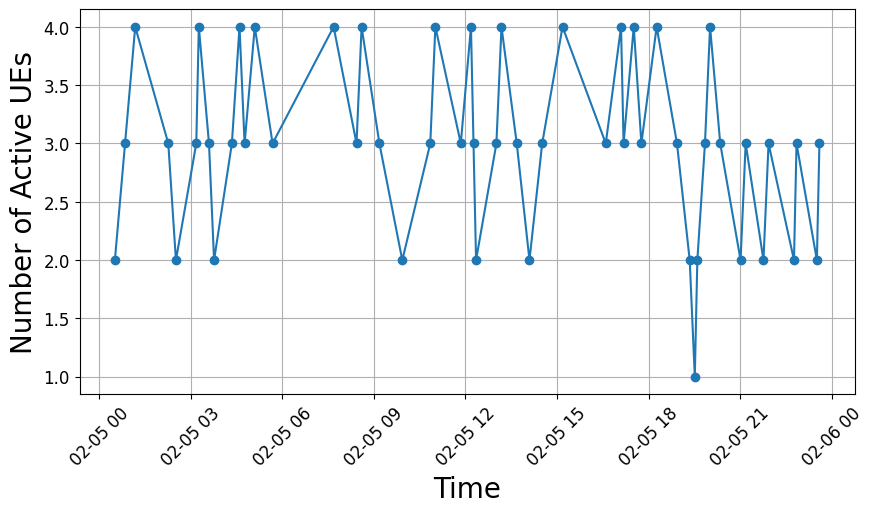

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
handover_df = pd.read_csv("/home/henokbfg/testbed/core dataset/03 Feb 2025 - 18 Feb 2025/df_location.csv", parse_dates=["time"])
session_df = pd.read_csv("/home/henokbfg/testbed/core dataset/03 Feb 2025 - 18 Feb 2025/df_active.csv", parse_dates=["timestamp"])
start_time = datetime(2025, 2, 5, 0, 0, 0)
end_time = datetime(2025, 2, 5, 23, 59, 59)
session_df['timestamp'] = pd.to_datetime(session_df['timestamp'])
# Filter the DataFrame
session_df = session_df[(session_df['timestamp'] >= start_time) & (session_df['timestamp'] <= end_time)]



# Figure 2: Most Frequent Handover Routes
handover_df.sort_values(by=["supi", "time"], inplace=True)
handover_df["PreviousCell"] = handover_df.groupby("supi")["NrCellId"].shift(1)
handover_routes = handover_df[handover_df["PreviousCell"].notna()].groupby(["PreviousCell", "NrCellId"]).size().reset_index(name="HandoverCount")
handover_routes = handover_routes.sort_values(by="HandoverCount", ascending=False).head(10)
plt.figure(figsize=(10, 5))
plt.barh(handover_routes.apply(lambda x: f"{int(x['PreviousCell'])} → {int(x['NrCellId'])}", axis=1), handover_routes["HandoverCount"], color='skyblue')
plt.xlabel("Number of Handovers", fontsize=20)
plt.ylabel("Handover Routes", fontsize=20)
# plt.title("Most Frequent Handover Routes")
plt.gca().invert_yaxis()
plt.savefig("handover_routes.png")
plt.show()

# Figure 3: Average Time Before Handover Per Cell
handover_df["TimeDiff"] = handover_df.groupby("supi")["time"].diff().dt.total_seconds()
time_per_cell = handover_df.groupby("PreviousCell")["TimeDiff"].mean().reset_index()
time_per_cell = time_per_cell.dropna()
plt.figure(figsize=(10, 5))
plt.bar(time_per_cell["PreviousCell"].astype(int).astype(str), time_per_cell["TimeDiff"], color='coral')
plt.xlabel("Cell ID", fontsize=20)
plt.ylabel("Average Time (seconds)", fontsize=20)
# plt.title("Average Time Before Handover Per Cell")
plt.savefig("handover_time_per_cell.png")
plt.show()


# Figure 6: Active UE Changes Over Time
plt.figure(figsize=(10, 5))
plt.plot(session_df["timestamp"], session_df["active_UEs"], marker='o', linestyle='-')
plt.xlabel("Time", fontsize=20)
plt.ylabel("Number of Active UEs", fontsize=20)
# plt.title("Active UE Count Over Time")
plt.xticks(rotation=45)
plt.grid()
# plt.savefig("active_ue_over_time.png")
plt.savefig("active_ue_over_time.pdf", dpi=800, format='pdf')
plt.show()

## intent testing

In [ ]:
import json
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from dotenv import load_dotenv
from openai import OpenAI

# Load environment variables
load_dotenv()
api_key = os.getenv('API_KEY')
client = OpenAI(api_key=api_key)

def load_intent_prompts(file_path):
    intent_categories = {}
    category = None
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line.startswith('##'):
                category = line.strip('#').strip()
                intent_categories[category] = []
            elif category and line:
                intent_categories[category].append(line.split('. ', 1)[-1])  # Remove numbering
    return intent_categories

intent_file_path = "intent prompts.txt"
test_file_path = "test_prompts.txt"
intent_categories = load_intent_prompts(intent_file_path)
test_intents = load_intent_prompts(test_file_path) 

# Create global variables to store all intents and their categories
all_intents = []
all_categories = []
intent_to_category = {}
intent_embeddings = None

# Generate embeddings using OpenAI Embeddings API
def get_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-ada-002"  # or "text-embedding-3-small" 
    )
    return response.data[0].embedding

# Generate and store embeddings for all intents
def prepare_intent_embeddings():
    global all_intents, all_categories, intent_to_category, intent_embeddings
    
    # Collect all intents and their categories
    for category, intents in intent_categories.items():
        for intent in intents:
            all_intents.append(intent)
            all_categories.append(category)
            intent_to_category[intent] = category
    
    # Generate embeddings for all intents
    print(f"Generating embeddings for {len(all_intents)} intents...")
    intent_embeddings = []
    
    # Process in batches to avoid rate limits
    batch_size = 20
    for i in range(0, len(all_intents), batch_size):
        batch = all_intents[i:i+batch_size]
        batch_response = client.embeddings.create(
            input=batch,
            model="text-embedding-ada-002"
        )
        batch_embeddings = [item.embedding for item in batch_response.data]
        intent_embeddings.extend(batch_embeddings)
        print(f"Processed {i+len(batch)}/{len(all_intents)} intents")
    
    intent_embeddings = np.array(intent_embeddings)
    print(f"Generated embeddings for {len(all_intents)} intents")

def get_best_intent_match_rag(user_query):
    """Use RAG approach to find the best matching intent"""
    # Get query embedding
    query_embedding = get_embedding(user_query)
    
    # Calculate similarity with all intents
    similarities = cosine_similarity([query_embedding], intent_embeddings)[0]
    
    # Get most similar intent
    best_idx = np.argmax(similarities)
    best_match = all_intents[best_idx]
    best_score = similarities[best_idx]
    
    # Find the category of the matched intent
    category = intent_to_category.get(best_match)
    
    # Get top 3 matches for logging/debugging
    top_indices = similarities.argsort()[-3:][::-1]
    top_intents = [all_intents[idx] for idx in top_indices]
    top_scores = [similarities[idx] for idx in top_indices]
    top_matches = list(zip(top_intents, top_scores))
    
    return best_match, category, best_score, top_matches

def test_intent_matching():
    # Prepare embeddings first
    prepare_intent_embeddings()
    
    total_tests = 0
    correct_matches = 0
    mismatches = []
    
    # Track confidence scores for analysis
    confidence_scores = []
    
    total_queries = sum(len(test_queries) for test_queries in test_intents.values())
    processed_queries = 0
    
    for category, test_queries in test_intents.items():
        for query in test_queries:
            total_tests += 1
            predicted_intent, predicted_category, confidence, top_matches = get_best_intent_match_rag(query)
            confidence_scores.append(confidence)
            
            if predicted_category == category:
                correct_matches += 1
                print(f"✓ Correct match #{correct_matches}: Score={confidence:.4f}")
            else:
                mismatches.append((query, predicted_intent, predicted_category, category, confidence, top_matches))
                print(f"✗ Incorrect match #{len(mismatches)}: Score={confidence:.4f}")
                print(f"Query: {query}")
                print(f"Predicted: {predicted_intent} ({predicted_category})")
                print(f"Actual: {category}")
                print(f"Top matches: {top_matches}\n")
            
            processed_queries += 1
            if processed_queries % 10 == 0 or processed_queries == total_queries:
                print(f"Progress: {processed_queries}/{total_queries} queries processed...")
    
    accuracy = (correct_matches / total_tests) * 100 if total_tests > 0 else 0
    
    # Analyze confidence scores
    avg_confidence = sum(confidence_scores) / len(confidence_scores) if confidence_scores else 0
    median_confidence = sorted(confidence_scores)[len(confidence_scores)//2] if confidence_scores else 0
    correct_confidences = [score for i, score in enumerate(confidence_scores) 
                          if i < (correct_matches)]
    incorrect_confidences = [m[4] for m in mismatches]
    
    avg_correct_conf = sum(correct_confidences) / len(correct_confidences) if correct_confidences else 0
    avg_incorrect_conf = sum(incorrect_confidences) / len(incorrect_confidences) if incorrect_confidences else 0
    
    print("\nIntent Matching Performance:")
    print(f"Average confidence score: {avg_confidence:.4f}")
    print(f"Median confidence score: {median_confidence:.4f}")
    print(f"Average confidence for correct matches: {avg_correct_conf:.4f}")
    print(f"Average confidence for incorrect matches: {avg_incorrect_conf:.4f}")
    
    if mismatches:
        print("\nMismatched Cases:")
        for query, intent, predicted, actual, conf, top in mismatches:
            print(f"Query: {query}")
            print(f"Predicted: {intent} ({predicted}), Confidence: {conf:.4f}")
            print(f"Actual: {actual}")
            print(f"Top matches: {top}\n")
    
    print(f"\nIntent Matching Accuracy: {accuracy:.2f}%")
    print(f"Total Tests: {total_tests}, Correct Matches: {correct_matches}, Mismatches: {len(mismatches)}")
    
    # Suggest confidence threshold based on results
    if correct_confidences and incorrect_confidences:
        print("\nConfidence Score Analysis:")
        possible_thresholds = [0.85, 0.88, 0.9, 0.92, 0.95]
        for threshold in possible_thresholds:
            above_threshold = sum(1 for score in confidence_scores if score >= threshold)
            correct_above = sum(1 for score in correct_confidences if score >= threshold)
            if above_threshold > 0:
                precision_at_threshold = correct_above / above_threshold
                recall_at_threshold = correct_above / len(correct_confidences) if correct_confidences else 0
                print(f"Threshold {threshold}: Precision={precision_at_threshold:.2f}, " +
                      f"Recall={recall_at_threshold:.2f}, Coverage={above_threshold/len(confidence_scores):.2f}")

# Add a hybrid version that uses both embeddings and GPT-4o for classification
def get_best_intent_match_hybrid(user_query, top_k=5):
    """Use RAG approach with GPT-4o to find the best matching intent"""
    # Get query embedding
    query_embedding = get_embedding(user_query)
    
    # Calculate similarity with all intents
    similarities = cosine_similarity([query_embedding], intent_embeddings)[0]
    
    # Get top_k most similar intents
    top_indices = similarities.argsort()[-top_k:][::-1]
    top_intents = [all_intents[idx] for idx in top_indices]
    top_scores = [similarities[idx] for idx in top_indices]
    
    # If the top score is very high (>0.92), we can return directly without LLM
    if top_scores[0] > 0.92 and top_scores[0] - top_scores[1] > 0.05:
        best_match = top_intents[0]
        category = intent_to_category.get(best_match)
        return best_match, category, "embedding", top_scores[0]
    
    # Otherwise, send to GPT-4o for final decision among top candidates
    intent_list_prompt = "\n".join([f"{intent}" for intent in top_intents])
    prompt = (
        "You are an intent matching assistant. Given a user query, select the most relevant intent from the list below.\n\n"
        "User Query: " + user_query + "\n\n"
        "Available Intents:\n" + intent_list_prompt + "\n\n"
        "STRICT REQUIREMENT. Return the best matching intent exactly as it appears in the Available Intents. Do not add any extra text, letter, number, hyphen, dot or anything. This is very Important"
    )
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "system", "content": "You match user queries to predefined intents."},
                 {"role": "user", "content": prompt}],
    )
    best_match = response.choices[0].message.content.strip()
    
    # Find the category of the matched intent
    category = intent_to_category.get(best_match)
    
    # Get the confidence score for the selected intent
    best_idx = all_intents.index(best_match) if best_match in all_intents else -1
    confidence = similarities[best_idx] if best_idx >= 0 else 0
    
    return best_match, category, "llm", confidence

if __name__ == "__main__":
    print("Testing pure embedding-based RAG intent matching...")
    test_intent_matching()
    
    # Uncomment to test the hybrid approach
    # print("\nHybrid approach is also available via get_best_intent_match_hybrid function")

In [ ]:

import json
import os
# from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load environment variables
# load_dotenv()

# Initialize sentence transformer model for embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def load_intent_prompts(file_path):
    intent_categories = {}
    category = None
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line.startswith('##'):
                category = line.strip('#').strip()
                intent_categories[category] = []
            elif category and line:
                intent_categories[category].append(line.split('. ', 1)[-1])  # Remove numbering
    return intent_categories

intent_file_path = "intent prompts.txt"
test_file_path = "test_prompts.txt"
intent_categories = load_intent_prompts(intent_file_path)
test_intents = load_intent_prompts(test_file_path) 

# Create global variables to store all intents and their embeddings
all_intents = []
all_categories = []
intent_to_category = {}
intent_embeddings = None

# Generate and store embeddings for all intents
def prepare_intent_embeddings():
    global all_intents, all_categories, intent_to_category, intent_embeddings
    
    # Collect all intents and their categories
    for category, intents in intent_categories.items():
        for intent in intents:
            all_intents.append(intent)
            all_categories.append(category)
            intent_to_category[intent] = category
    
    # Generate embeddings for all intents
    intent_embeddings = embedding_model.encode(all_intents)
    print(f"Generated embeddings for {len(all_intents)} intents")

def get_best_intent_match_rag(user_query):
    """Use only RAG approach to find the best matching intent"""
    # Get query embedding
    query_embedding = embedding_model.encode([user_query])[0]
    
    # Calculate similarity with all intents
    similarities = cosine_similarity([query_embedding], intent_embeddings)[0]
    
    # Get most similar intent
    best_idx = np.argmax(similarities)
    best_match = all_intents[best_idx]
    best_score = similarities[best_idx]
    
    # Find the category of the matched intent
    category = intent_to_category.get(best_match)
    
    # Get top 3 matches for logging/debugging
    top_indices = similarities.argsort()[-3:][::-1]
    top_intents = [all_intents[idx] for idx in top_indices]
    top_scores = [similarities[idx] for idx in top_indices]
    top_matches = list(zip(top_intents, top_scores))
    
    return best_match, category, best_score, top_matches

def test_intent_matching():
    # Prepare embeddings first
    prepare_intent_embeddings()
    
    total_tests = 0
    correct_matches = 0
    mismatches = []
    
    # Track confidence scores for analysis
    confidence_scores = []
    
    total_queries = sum(len(test_queries) for test_queries in test_intents.values())
    processed_queries = 0
    
    for category, test_queries in test_intents.items():
        for query in test_queries:
            total_tests += 1
            predicted_intent, predicted_category, confidence, top_matches = get_best_intent_match_rag(query)
            confidence_scores.append(confidence)
            
            if predicted_category == category:
                correct_matches += 1
                print(f"✓ Correct match #{correct_matches}: Score={confidence:.4f}")
            else:
                mismatches.append((query, predicted_intent, predicted_category, category, confidence, top_matches))
                print(f"✗ Incorrect match #{len(mismatches)}: Score={confidence:.4f}")
                print(f"Query: {query}")
                print(f"Predicted: {predicted_intent} ({predicted_category})")
                print(f"Actual: {category}")
                print(f"Top matches: {top_matches}\n")
            
            processed_queries += 1
            if processed_queries % 10 == 0 or processed_queries == total_queries:
                print(f"Progress: {processed_queries}/{total_queries} queries processed...")
    
    accuracy = (correct_matches / total_tests) * 100 if total_tests > 0 else 0
    
    # Analyze confidence scores
    avg_confidence = sum(confidence_scores) / len(confidence_scores) if confidence_scores else 0
    median_confidence = sorted(confidence_scores)[len(confidence_scores)//2] if confidence_scores else 0
    correct_confidences = [score for i, score in enumerate(confidence_scores) 
                          if i < len(confidence_scores) - len(mismatches)]
    incorrect_confidences = [m[4] for m in mismatches]
    
    avg_correct_conf = sum(correct_confidences) / len(correct_confidences) if correct_confidences else 0
    avg_incorrect_conf = sum(incorrect_confidences) / len(incorrect_confidences) if incorrect_confidences else 0
    
    print("\nIntent Matching Performance:")
    print(f"Average confidence score: {avg_confidence:.4f}")
    print(f"Median confidence score: {median_confidence:.4f}")
    print(f"Average confidence for correct matches: {avg_correct_conf:.4f}")
    print(f"Average confidence for incorrect matches: {avg_incorrect_conf:.4f}")
    
    if mismatches:
        print("\nMismatched Cases:")
        for query, intent, predicted, actual, conf, top in mismatches:
            print(f"Query: {query}")
            print(f"Predicted: {intent} ({predicted}), Confidence: {conf:.4f}")
            print(f"Actual: {actual}")
            print(f"Top matches: {top}\n")
    
    print(f"\nIntent Matching Accuracy: {accuracy:.2f}%")
    print(f"Total Tests: {total_tests}, Correct Matches: {correct_matches}, Mismatches: {len(mismatches)}")
    
    # Suggest confidence threshold based on results
    if correct_confidences and incorrect_confidences:
        print("\nConfidence Score Analysis:")
        possible_thresholds = [0.7, 0.75, 0.8, 0.85, 0.9]
        for threshold in possible_thresholds:
            above_threshold = sum(1 for score in confidence_scores if score >= threshold)
            correct_above = sum(1 for score in correct_confidences if score >= threshold)
            if above_threshold > 0:
                precision_at_threshold = correct_above / above_threshold
                recall_at_threshold = correct_above / len(correct_confidences) if correct_confidences else 0
                print(f"Threshold {threshold}: Precision={precision_at_threshold:.2f}, " +
                      f"Recall={recall_at_threshold:.2f}, Coverage={above_threshold/len(confidence_scores):.2f}")

if __name__ == "__main__":
    test_intent_matching()

# load prometheus data into dataframes

In [2]:
df_destination = pd.DataFrame()
df_reg = pd.DataFrame()
df_active = pd.DataFrame()
df_location = pd.DataFrame()


In [ ]:
def get_df_location(start_time=None, end_time=None):
    # Query Prometheus
    query='UE_location_report'
    metric_data = prom.custom_query_range(
        query=query,
        start_time=start_time,
        end_time=end_time,
        step='5m'  # 1 minute intervals, adjust as needed
    )
    
    # Process the data into a list of dictionaries
    records = []
    for entry in metric_data:
        metric = entry['metric']
        # Extract only the desired labels
        record = {
            'time': metric['time'],
            'NrCellId': metric['NrCellId'],
            'supi': metric['supi'],
            'tac': metric['tac']
            
        }
        records.append(record)
    
    # Convert to DataFrame
    df = pd.DataFrame(records)

    # Convert time string to datetime
    # Remove 'UTC' and trailing timezone info for clean parsing
    df['time'] = df['time'].apply(lambda x: pd.to_datetime(x.split('+')[0].strip()))
    # Sort by 'supi' and 'time'
    
    df = df.sort_values(by=['supi', 'time'])
    # Drop consecutive rows with the same 'supi' and 'NrCellId'
    df = df.loc[
        ~(df['supi'] == df['supi'].shift()) | 
        ~(df['NrCellId'] == df['NrCellId'].shift())
    ]
    # df_location = df_location.sort_values('time')

    # # Reset the index if needed
    # df_location = df_location.reset_index(drop=True)
    # Sort by time
    df = df.sort_values('time')
    df['time'] = df['time'] + pd.Timedelta(hours=4)
    df['supi'] = df['supi'].str.extract(r'imsi-(\d+)').astype(str)

    # Reset index after sorting
    df = df.reset_index(drop=True)
    
    return df
def get_df_destination(start_time=None, end_time=None):
    # Query Prometheus
    metric_data = prom.custom_query_range(
        query='ue_destination_visits_total',
        start_time=start_time,
        end_time=end_time,
        step='5m'  # 1 minute intervals, adjust as needed
    )
    
    # Process the data into a list of dictionaries
    records = []
    for entry in metric_data:
        metric = entry['metric']
        # Extract only the desired labels
        record = {
            'time': metric['timestamp'],
            'supi': metric['supi'],
            'location_type': metric['location_type'],
            'duration': metric['duration'],
            'time_of_day': metric['time_of_day']
        }
        records.append(record)
    
    # Convert to DataFrame
    df = pd.DataFrame(records)

    # Convert time string to datetime
    # Remove 'UTC' and trailing timezone info for clean parsing
    df['time'] = df['time'].apply(lambda x: pd.to_datetime(x.split('+')[0].strip()))


    df = df.sort_values(by=['supi', 'time'])
    # Drop consecutive rows with the same 'supi' and 'NrCellId'
    df = df.loc[
        ~(df['supi'] == df['supi'].shift()) | 
        ~(df['location_type'] == df['location_type'].shift())
    ]
    
    # Sort by time
    df = df.sort_values('time')
    
    # Reset index after sorting
    df = df.reset_index(drop=True)
    
    return df

def get_df_active(start_time=None, end_time=None):
    
    
    # Query Prometheus
    query = 'active_UEs{state="current"}'
    result = prom.custom_query_range(
        query=query,
        start_time=start_time,
        end_time=end_time,
        step='5m'  # 30 minute intervals, adjust as needed
    )
    
    # Convert to DataFrame
    if result and len(result) > 0:
        # Extract timestamps and values
        data = result[0]['values']  # values is a list of [timestamp, value] pairs
        df = pd.DataFrame(data, columns=['timestamp', 'active_UEs'])
        
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        
        # Convert active_UEs to numeric
        df['active_UEs'] = pd.to_numeric(df['active_UEs'])

        # Remove duplicate consecutive values
        df = df[df['active_UEs'].shift() != df['active_UEs']]
        df['duration'] = (df['timestamp'].shift(-1) - df['timestamp']).fillna(pd.Timedelta(seconds=0))

        # Reset index after sorting
        df = df.reset_index(drop=True)
        df['timestamp'] = df['timestamp'] + pd.Timedelta(hours=4)

        return df
    else:
        return pd.DataFrame(columns=['timestamp', 'active_UEs'])

def get_reg(start_time=None, end_time=None):
    
    # Query Prometheus - filter for metrics with SUPI label
    query = 'amf_ue_registration_state{supi=~".+"}'
    result = prom.custom_query_range(
        query=query,
        start_time=start_time,
        end_time=end_time,
        step='5m' # 5 minute intervals, adjust as needed
    )
    
    # Convert to DataFrame
    dataframes = []
    
    if result:
        for metric in result:
            # Extract SUPI from metric metadata
            supi = metric['metric'].get('supi', 'unknown')
            
            # Create DataFrame for this SUPI
            df = pd.DataFrame(metric['values'], columns=['timestamp', 'state'])
            df['supi'] = supi
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
            df['state'] = pd.to_numeric(df['state'])
            
            # Keep only state changes
            df = df[df['state'].shift() != df['state']]
            
            dataframes.append(df)
    
    if dataframes:
        # Combine all SUPIs into one DataFrame
        final_df = pd.concat(dataframes, ignore_index=True)
        
        # Sort by timestamp
        final_df = final_df.sort_values('timestamp')
        
      
        
        # Add state description
        final_df['state_desc'] = final_df['state'].map({1: 'active', 0: 'inactive'})
        
        # Reorder columns
        final_df = final_df[['timestamp', 'supi', 'state', 'state_desc']]#, 'duration_minutes']]
        final_df = final_df.drop('state', axis=1)
        final_df = final_df.sort_values(by=['supi', 'timestamp'])

        # Calculate duration in minutes
        final_df['duration_minutes'] = (
            final_df.groupby('supi')['timestamp'].diff().shift(-1).dt.total_seconds() / 60
        )
        final_df = final_df.sort_values(by='timestamp')
        final_df['timestamp'] = final_df['timestamp'] + pd.Timedelta(hours=4)
        # Reset index after sorting
        final_df = final_df.reset_index(drop=True)
    
        return final_df
    else:
        return pd.DataFrame(columns=['timestamp', 'supi', 'state', 'state_desc', 'duration_minutes'])

def get_current_registrations():
    
    query = 'amf_ue_registration_state{supi=~".+"}'
    result = prom.custom_query(query)
    
    if result:
        data = []
        for metric in result:
            data.append({
                'supi': metric['metric'].get('supi', 'unknown'),
                'state': int(metric['value'][1]),
                'state_desc': 'active' if int(metric['value'][1]) == 1 else 'inactive'
            })
        return pd.DataFrame(data)
        
    else:
        return pd.DataFrame(columns=['supi', 'state', 'state_desc'])

def merge_location_handover(destination_df, handover_df):
    
    # Sort handover_df by time to ensure we get the most recent handover
    handover_df = handover_df.sort_values('time')
    
    # Initialize empty list to store NrCellIds
    cell_ids = []
    
    # For each location record
    for _, location_row in destination_df.iterrows():
        # Get all handovers for this SUPI before the location timestamp
        relevant_handovers = handover_df[
            (handover_df['supi'] == str(location_row['supi'])) & 
            (handover_df['time'] <= location_row['time'])
        ]
        
        if len(relevant_handovers) > 0:
            # Get the most recent handover's NrCellId
            cell_id = relevant_handovers.iloc[-1]['NrCellId']
        else:
            # If no previous handover found
            cell_id = None
            
        cell_ids.append(cell_id)
    
    # Add the NrCellId column to location_df
    destination_df['NrCellId'] = cell_ids
    
    return destination_df

In [4]:
# df_destination = get_df_destination(start_time, end_time)
# df_reg = get_reg(start_time, end_time)
# df_active = get_df_active(start_time, end_time)
df_location = get_df_location(start_time, end_time)
# df_loc_des = merge_location_handover(df_destination.copy(), df_location)

# display(df_destination.head())
# display(df_reg.head(10))
# display(df_active.head(10))
display(df_location.head())
# display(df_loc_des.head())

# display(df_destination.tail())
# display(df_reg.tail())
# display(df_active.tail())
display(df_location.tail())
# display(df_loc_des.tail())


,time,NrCellId,supi,tac
0,2025-03-14 09:51:12.024148523,000000060,208930000000001,000001
1,2025-03-14 09:51:35.536421750,000000050,208930000000002,000002
2,2025-03-14 09:51:45.352101850,000000050,208930000000003,000002
3,2025-03-14 09:52:10.679796546,000000050,208930000000004,000002
4,2025-03-14 10:02:50.658366976,000000060,208930000000002,000001


,time,NrCellId,supi,tac
8195,2025-04-07 08:39:09.556649983,000000030,208930000000003,000004
8196,2025-04-07 08:40:32.959131187,000000050,208930000000004,000002
8197,2025-04-07 08:43:27.164538952,000000050,208930000000003,000002
8198,2025-04-07 08:43:38.679066240,000000060,208930000000002,000001
8199,2025-04-07 08:51:48.878786173,000000050,208930000000002,000002


In [5]:
df_location.to_csv('df_8199.csv', index=False)  # Don't save the index as a column


In [5]:
df_location.to_csv('df_location.csv', index=False)  # Don't save the index as a column
df_active.to_csv('df_active.csv', index=False)  # Don't save the index as a column
df_destination.to_csv('df_destination.csv', index=False)  # Don't save the index as a column
df_reg.to_csv('df_reg.csv', index=False)  # Don't save the inde x as a column
df_loc_des.to_csv('df_loc_des.csv', index=False)  # Don't save the index as a column

# Load directly from csv

In [ ]:
df_location = pd.read_csv('df_location.csv')
df_active = pd.read_csv('df_active.csv')
df_destination = pd.read_csv('df_destination.csv')
df_reg = pd.read_csv('df_reg.csv')
df_loc_des = pd.read_csv('df_loc_des.csv')

display(df_destination.tail())
display(df_reg.tail())
display(df_active.tail())
display(df_location.tail())
display(df_loc_des.tail())


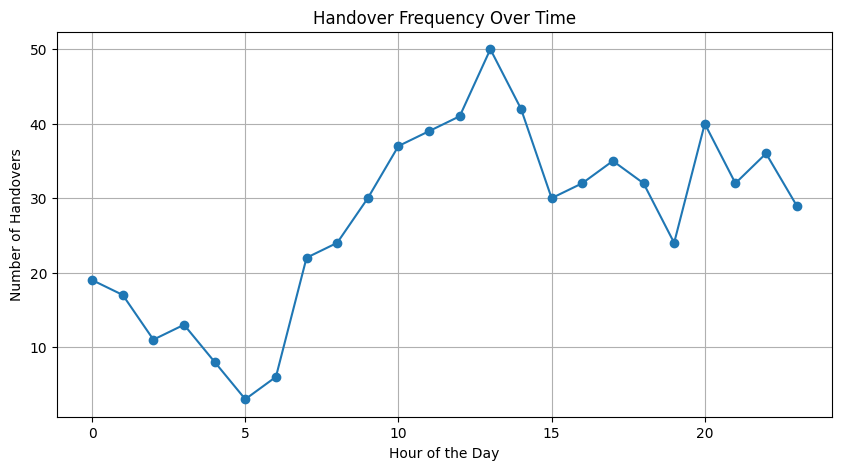

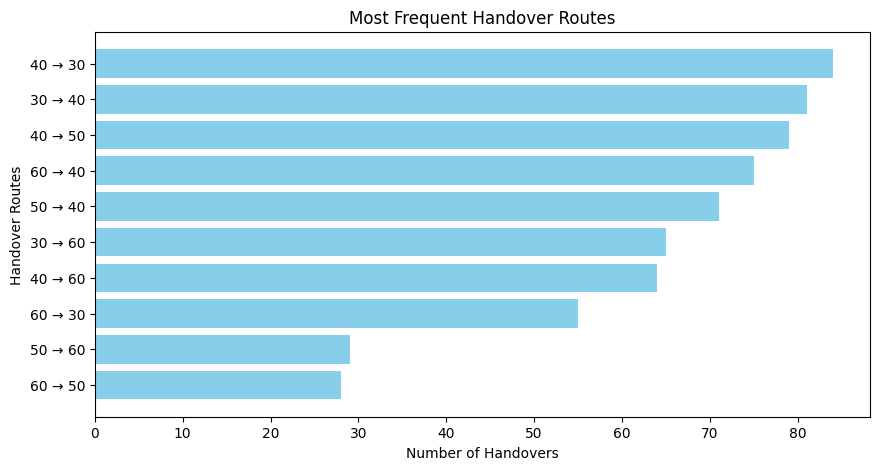

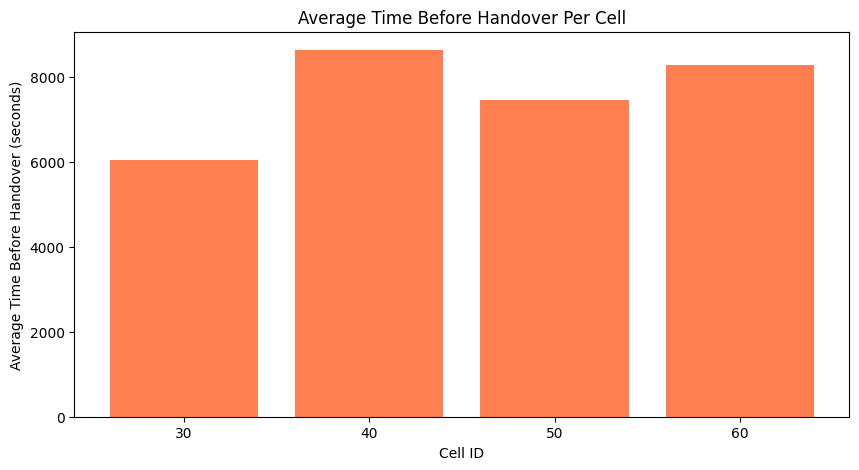

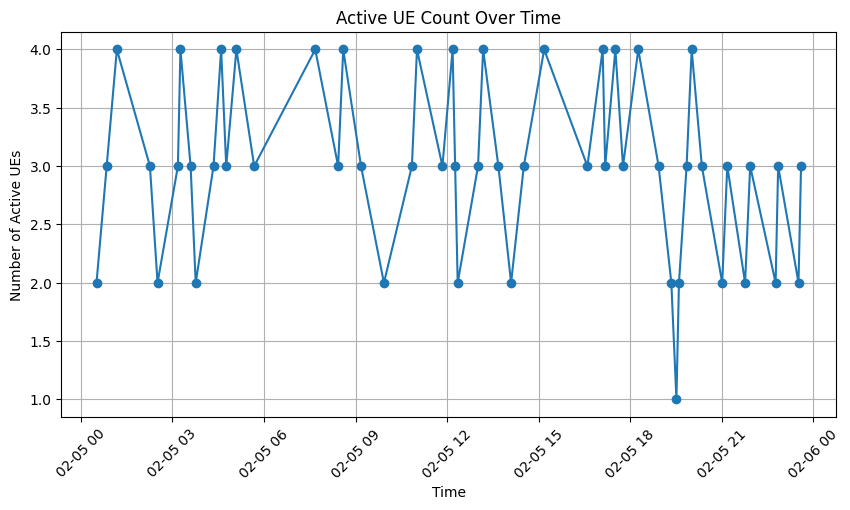

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
handover_df = pd.read_csv("df_location.csv", parse_dates=["time"])
session_df = pd.read_csv("df_active.csv", parse_dates=["timestamp"])
start_time = datetime(2025, 2, 5, 0, 0, 0)
end_time = datetime(2025, 2, 5, 23, 59, 59)
session_df['timestamp'] = pd.to_datetime(session_df['timestamp'])
# Filter the DataFrame
session_df = session_df[(session_df['timestamp'] >= start_time) & (session_df['timestamp'] <= end_time)]

# Figure 1: Handover Frequency Over Time
handover_df["hour"] = handover_df["time"].dt.hour
handover_timeline = handover_df.groupby("hour")["NrCellId"].count()
plt.figure(figsize=(10, 5))
plt.plot(handover_timeline.index, handover_timeline.values, marker='o')
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Handovers")
plt.title("Handover Frequency Over Time")
plt.grid()
plt.savefig("handover_frequency.png")
plt.show()

# Figure 2: Most Frequent Handover Routes
handover_df.sort_values(by=["supi", "time"], inplace=True)
handover_df["PreviousCell"] = handover_df.groupby("supi")["NrCellId"].shift(1)
handover_routes = handover_df[handover_df["PreviousCell"].notna()].groupby(["PreviousCell", "NrCellId"]).size().reset_index(name="HandoverCount")
handover_routes = handover_routes.sort_values(by="HandoverCount", ascending=False).head(10)
plt.figure(figsize=(10, 5))
plt.barh(handover_routes.apply(lambda x: f"{int(x['PreviousCell'])} → {int(x['NrCellId'])}", axis=1), handover_routes["HandoverCount"], color='skyblue')
plt.xlabel("Number of Handovers")
plt.ylabel("Handover Routes")
plt.title("Most Frequent Handover Routes")
plt.gca().invert_yaxis()
plt.savefig("handover_routes.png")
plt.show()

# Figure 3: Average Time Before Handover Per Cell
handover_df["TimeDiff"] = handover_df.groupby("supi")["time"].diff().dt.total_seconds()
time_per_cell = handover_df.groupby("PreviousCell")["TimeDiff"].mean().reset_index()
time_per_cell = time_per_cell.dropna()
plt.figure(figsize=(10, 5))
plt.bar(time_per_cell["PreviousCell"].astype(int).astype(str), time_per_cell["TimeDiff"], color='coral')
plt.xlabel("Cell ID")
plt.ylabel("Average Time Before Handover (seconds)")
plt.title("Average Time Before Handover Per Cell")
plt.savefig("handover_time_per_cell.png")
plt.show()

# Figure 5: UE Session Duration Distribution
# session_df["duration_seconds"] = pd.to_timedelta(session_df["duration"]).dt.total_seconds()
# plt.figure(figsize=(10, 5))
# plt.hist(session_df["duration_seconds"].dropna(), bins=20, color='purple', edgecolor='black')
# plt.xlabel("Session Duration (seconds)")
# plt.ylabel("Frequency")
# plt.title("Distribution of UE Session Durations")
# plt.savefig("ue_session_duration.png")
# plt.show()

# Figure 6: Active UE Changes Over Time
plt.figure(figsize=(10, 5))
plt.plot(session_df["timestamp"], session_df["active_UEs"], marker='o', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Number of Active UEs")
plt.title("Active UE Count Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.savefig("active_ue_over_time.png")
plt.show()

# analysis on df_reg

In [93]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def load_and_prepare_data(data):
    # Load the dataset
    # data = pd.read_csv(file_path)

    # Drop rows where 'duration_minutes' is NaN for training purposes
    train_data = data.dropna(subset=['duration_minutes'])
    train_data['index'] = train_data.index  # Add index as a column to use as a feature

    return data, train_data

def train_models(train_data):
    # Group data by 'supi' and 'state_desc' and train models
    grouped = train_data.groupby(['supi', 'state_desc'])
    models = {}
    for (supi, state), group in grouped:
        X = group['index'].values.reshape(-1, 1)  # Using index as the feature
        y = group['duration_minutes']
        model = LinearRegression()
        model.fit(X, y)
        models[(supi, state)] = model
    return models

def predict_duration(supi, data, models):
    # Find the most recent entry for the specified supi
    last_entry = data[data['supi'] == supi].iloc[-1]
    print(f"the supi {supi} is currently in {last_entry['state_desc']} state")
    if pd.isna(last_entry['duration_minutes']):
        model_key = (supi, last_entry['state_desc'])
        if model_key in models:
            # Predict using the index of the last entry
            index_value = last_entry.name
            predicted_duration = models[model_key].predict(np.array([[index_value]]))[0]
            return predicted_duration
        else:
            return "No model available for this supi and state combination"
    else:
        return "Last entry already has a duration value"

# Usage
data = df_reg.copy()  # Specify the path to your dataset
data, train_data = load_and_prepare_data(data)
models = train_models(train_data)

# Example call
supi_to_predict = 'imsi-208930000000001'  # Change this to the supi you want to test
predicted_duration = predict_duration(supi_to_predict, data, models)
print(f'and Predicted duration is: {predicted_duration}')


the supi imsi-208930000000001 is currently in inactive state
and Predicted duration is: 55.482319113052625


/tmp/ipykernel_389008/1060682227.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['index'] = train_data.index  # Add index as a column to use as a feature


# analysis on df_active

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression

# Load the data
data = df_active.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['duration'] = pd.to_timedelta(data['duration'])

# Feature engineering
data['hour_of_day'] = data['timestamp'].dt.hour
data['minute_of_hour'] = data['timestamp'].dt.minute
data['day_of_week'] = data['timestamp'].dt.dayofweek

# Prepare target variables
duration_seconds = data['duration'].dt.total_seconds()
label_encoder = LabelEncoder()
active_ues_encoded = label_encoder.fit_transform(data['active_UEs'])

# Split the dataset into training and testing sets
X = data[['hour_of_day', 'minute_of_hour', 'day_of_week']]
y_duration = duration_seconds
y_active_ues = active_ues_encoded

X_train, X_test, y_duration_train, y_duration_test, y_active_ues_train, y_active_ues_test = train_test_split(
    X, y_duration, y_active_ues, test_size=0.2, random_state=42)

# Initialize the models
model_duration = LinearRegression()
model_active_ues = LogisticRegression(max_iter=200)  # Increase max_iter if needed for convergence

# Train the models
model_duration.fit(X_train, y_duration_train)
model_active_ues.fit(X_train, y_active_ues_train)

# Predicting the next entry
next_timestamp_index = data.index[-1] + 1  # hypothetically the next index
next_timestamp_features = data.loc[next_timestamp_index - 1, ['hour_of_day', 'minute_of_hour', 'day_of_week']].values.reshape(1, -1)

predicted_duration_seconds = model_duration.predict(next_timestamp_features)
predicted_active_ues = label_encoder.inverse_transform(model_active_ues.predict(next_timestamp_features).reshape(-1))

# Calculate the next timestamp by adding the predicted duration to the last timestamp
last_timestamp = data['timestamp'].iloc[-1]
predicted_duration_timedelta = pd.to_timedelta(predicted_duration_seconds[0], unit='s')
predicted_next_timestamp = last_timestamp + predicted_duration_timedelta

print(f"Duration for current status: {predicted_duration_timedelta}, Predicted next entry: Timestamp: {predicted_next_timestamp}, Predicted next Active UEs: {predicted_active_ues[0]} ")


Duration for current status: 0 days 00:20:30.285900663, Predicted next entry: Timestamp: 2025-02-04 16:06:15.285900663, Predicted next Active UEs: 3 


/home/henokbfg/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/henokbfg/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/henokbfg/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# Analysis on df_location

In [110]:
import pandas as pd


df = df_location.copy()
df['time'] = pd.to_datetime(df['time'])

# Sort by supi and time
df.sort_values(['supi', 'time'], inplace=True)

# For each record (except the last for a given supi), add the next cell and dwell time.
df['next_tac'] = df.groupby('supi')['tac'].shift(-1)
df['next_time'] = df.groupby('supi')['time'].shift(-1)
df['dwell_time'] = (df['next_time'] - df['time']).dt.total_seconds()

# Drop rows that don’t have a next handover (e.g., the last record per supi)
df_train = df.dropna(subset=['next_tac', 'dwell_time']).copy()

# Feature Engineering: Here we extract the hour of day from the timestamp.
df_train['hour'] = df_train['time'].dt.hour

# For our models, our features will be the current cell ('tac') and the hour of day.
features = ['tac', 'hour']
X = df_train[features]

# Labels for the two tasks:
y_next_tac = df_train['next_tac']       # For classification (predicting the next cell)
y_dwell_time = df_train['dwell_time']     # For regression (predicting the dwell time in seconds)

# print("Training Data:")
# print(df_train[['supi', 'time', 'tac', 'next_tac', 'dwell_time', 'hour']])

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing: One-hot encode the 'tac' column and pass through the 'hour' column.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['tac']),
        ('num', 'passthrough', ['hour'])
    ]
)

# Define the classification pipeline for predicting the next cell (tac)
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Define the regression pipeline for predicting dwell time (in seconds)
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the training data for each task (here we use 80% for training).
X_train, X_test, y_next_tac_train, y_next_tac_test = train_test_split(
    X, y_next_tac, test_size=0.2, random_state=42
)
_, _, y_dwell_time_train, y_dwell_time_test = train_test_split(
    X, y_dwell_time, test_size=0.2, random_state=42
)

# Train the models
clf_pipeline.fit(X_train, y_next_tac_train)
reg_pipeline.fit(X_train, y_dwell_time_train)

def predict_next_handover(supi_value, df, clf_model, reg_model):
    """
    Predicts the next cell (tac) and dwell time for the latest record of a given supi.
    
    Parameters:
      supi_value (str): The supi of the UE.
      df (DataFrame): The original DataFrame with historical records.
      clf_model: Trained classification model.
      reg_model: Trained regression model.
      
    Returns:
      tuple: (predicted_next_tac, predicted_dwell_time) or an error message.
    """
    # Filter records for the given supi
    df_supi = df[df['supi'] == supi_value].copy()
    if df_supi.empty:
        return f"No data available for supi {supi_value}"
    
    # Ensure the records are sorted by time and get the latest one.
    df_supi.sort_values('time', inplace=True)
    latest_record = df_supi.iloc[-1]
    
    # Prepare features from the latest record.
    current_features = pd.DataFrame({
        'tac': [latest_record['tac']],
        'hour': [latest_record['time'].hour]
    })
    
    # Use the trained models to predict next cell and dwell time.
    predicted_next_tac = clf_model.predict(current_features)[0]
    predicted_dwell_time = reg_model.predict(current_features)[0]
    
    return predicted_next_tac, predicted_dwell_time

# Example usage for a given supi:
supi_to_predict = "208930000000004"
prediction = predict_next_handover(supi_to_predict, df, clf_pipeline, reg_pipeline)
print(f"Predicted next TAC and dwell time (seconds) for supi {supi_to_predict}: {prediction}")



Predicted next TAC and dwell time (seconds) for supi 208930000000004: ('000003', 18682.563007586337)


In [50]:
from collections import defaultdict

def predict_ue_location(data, target_ue, target_time):
    # Convert time to datetime
    data['time'] = pd.to_datetime(data['time'])
    
    # Filter data for specific UE
    ue_data = data[data['supi'] == target_ue].copy()
    
    # Extract hour from timestamp
    ue_data['hour'] = ue_data['time'].dt.hour
    
    # Create time windows 
    def get_time_window(hour):
        if 5 <= hour < 11: return 'morning'
        elif 11 <= hour < 14: return 'lunch'
        elif 14 <= hour < 17: return 'afternoon'
        elif 17 <= hour < 24: return 'evening'
        else: return 'night'
    
    ue_data['time_window'] = ue_data['hour'].apply(get_time_window)
    
    # Calculate probabilities for each cell during each time window
    time_window_probs = defaultdict(lambda: defaultdict(int))
    
    for window in ['morning', 'lunch', 'afternoon', 'evening', 'night']:
        window_data = ue_data[ue_data['time_window'] == window]
        total_records = len(window_data)
        if total_records > 0:
            cell_counts = window_data['NrCellId'].value_counts()
            for cell in cell_counts.index:
                time_window_probs[window][cell] = cell_counts[cell] / total_records
    
    # Get time window for target time
    target_dt = datetime.strptime(target_time, '%Y-%m-%d %H:%M:%S')
    target_window = get_time_window(target_dt.hour)
    
    # Get probabilities for target time window
    cell_probs = time_window_probs[target_window]
    
    if not cell_probs:
        return "Insufficient data for prediction"
    
    # Get most likely cell
    most_likely_cell = max(cell_probs.items(), key=lambda x: x[1])
    # display(ue_data)
    
    return {
        'predicted_cell': most_likely_cell[0],
        'confidence': most_likely_cell[1],
        'all_probabilities': dict(cell_probs)
    }


prediction = predict_ue_location(
    df_location, 
    '208930000000004', 
    '2025-01-24 20:00:00'
)
print(prediction)

{'predicted_cell': '000000040', 'confidence': 0.42857142857142855, 'all_probabilities': {'000000040': 0.42857142857142855, '000000030': 0.2857142857142857, '000000050': 0.14285714285714285, '000000060': 0.14285714285714285}}


In [483]:

def markov_predict_location(data, target_ue, target_time):
    """
    Predicts UE location using a Markov Chain model with time-weighted transitions
    """
    # Convert time to datetime
    data['time'] = pd.to_datetime(data['time'])
    
    # Filter data for target UE
    ue_data = data[data['supi'] == target_ue].copy()
    ue_data = ue_data.sort_values('time')
    
    # Create transition matrix
    transitions = defaultdict(lambda: defaultdict(int))
    total_transitions = defaultdict(int)
    
    # Calculate time-based weights (more recent transitions get higher weights)
    max_time = ue_data['time'].max()
    ue_data['time_weight'] = (1 + (ue_data['time'] - ue_data['time'].min()) / 
                             np.timedelta64(1, 'h')/24)
    
    # Build transition matrix
    for i in range(len(ue_data) - 1):
        current_cell = ue_data.iloc[i]['NrCellId']
        next_cell = ue_data.iloc[i + 1]['NrCellId']
        weight = ue_data.iloc[i]['time_weight']
        
        transitions[current_cell][next_cell] += weight
        total_transitions[current_cell] += weight
    
    # Calculate transition probabilities
    transition_probs = {}
    for current_cell in transitions:
        transition_probs[current_cell] = {}
        for next_cell in transitions[current_cell]:
            prob = transitions[current_cell][next_cell] / total_transitions[current_cell]
            transition_probs[current_cell][next_cell] = prob
    
    # Get current state (most recent cell before target time)
    target_dt = datetime.strptime(target_time, '%Y-%m-%d %H:%M:%S')
    current_state = ue_data[ue_data['time'] <= target_dt].iloc[-1]['NrCellId']
    
    # Calculate time difference to adjust prediction
    time_diff = target_dt - ue_data[ue_data['time'] <= target_dt].iloc[-1]['time']
    hours_diff = time_diff.total_seconds() / 3600
    
    # If time difference is too large, factor in steady-state probabilities
    if hours_diff > 4:
        # Calculate steady-state probabilities
        cell_counts = ue_data['NrCellId'].value_counts(normalize=True)
        prediction_probs = cell_counts.to_dict()
    else:
        # Use transition probabilities
        prediction_probs = transition_probs.get(current_state, {})
        if not prediction_probs:
            prediction_probs = ue_data['NrCellId'].value_counts(normalize=True).to_dict()
    
    # Get most likely next cell
    if prediction_probs:
        predicted_cell = max(prediction_probs.items(), key=lambda x: x[1])
        return {
            'current_cell': current_state,
            'predicted_cell': predicted_cell[0],
            'confidence': predicted_cell[1],
            'all_probabilities': prediction_probs,
            'hours_to_prediction': hours_diff
        }
    else:
        return "Insufficient data for prediction"

# Calculate temporal patterns
def get_temporal_patterns(ue_data):
    ue_data['hour'] = ue_data['time'].dt.hour
    hourly_patterns = ue_data.groupby(['hour', 'NrCellId']).size().unstack(fill_value=0)
    return hourly_patterns.div(hourly_patterns.sum(axis=1), axis=0)

print("Predicting location using Markov Chain model...")
prediction = markov_predict_location(
    df_location, 
    '208930000000004', 
    '2025-01-24 11:00:00'
)
print(prediction)
print(get_temporal_patterns(df_location[df_location['supi'] == '208930000000004']))

Predicting location using Markov Chain model...
{'current_cell': '000000030', 'predicted_cell': '000000040', 'confidence': 0.4932904199979776, 'all_probabilities': {'000000040': 0.4932904199979776, '000000060': 0.27058650129726586, '000000050': 0.2361230787047564}, 'hours_to_prediction': 2.2376649308333336}
NrCellId  000000030  000000040  000000050  000000060
hour                                                
0          0.000000   1.000000   0.000000   0.000000
1          0.000000   0.500000   0.500000   0.000000
2          0.000000   1.000000   0.000000   0.000000
3          0.000000   0.500000   0.500000   0.000000
5          1.000000   0.000000   0.000000   0.000000
6          0.750000   0.000000   0.250000   0.000000
7          0.000000   0.000000   1.000000   0.000000
8          0.500000   0.500000   0.000000   0.000000
9          0.666667   0.000000   0.333333   0.000000
10         0.200000   0.200000   0.600000   0.000000
11         0.666667   0.333333   0.000000   0.000000
12

In [484]:
from statsmodels.tsa.arima.model import ARIMA

# Aggregate data to count transitions per hour
df_location['forecast'] = df_location['time'].dt.floor('h')
cell_counts = df_location.groupby(['forecast', 'NrCellId']).size().unstack(fill_value=0)

# Use ARIMA to predict the next hour's most visited cell
cell_id = '000000050'  # Example: Predict for a specific cell ID
model = ARIMA(cell_counts[cell_id], order=(1, 1, 1))
model_fit = model.fit()

# Forecast for the next hour
forecast = model_fit.forecast(steps=5)

# Generate future dates
last_date = cell_counts.index[-1] # Get the last date in the historical data
print(last_date)
future_dates = pd.date_range(last_date + pd.Timedelta(hours=1), periods=5, freq='h')

# Combine forecast with future dates
forecast_df = pd.DataFrame({'forecast': forecast.values}, index=future_dates)
display(cell_counts.tail())
print(f"Forecast of transition to {cell_id} for the next 5 hours:")
display(forecast_df)


2025-01-24 08:00:00


NrCellId,000000030,000000040,000000050,000000060
forecast,,,,
2025-01-24 04:00:00,0,1,0,0
2025-01-24 05:00:00,1,1,0,1
2025-01-24 06:00:00,1,0,1,0
2025-01-24 07:00:00,0,0,1,2
2025-01-24 08:00:00,1,2,0,1


Forecast of transition to 000000050 for the next 5 hours:


,forecast
2025-01-24 09:00:00,0.603526
2025-01-24 10:00:00,0.508623
2025-01-24 11:00:00,0.523547
2025-01-24 12:00:00,0.521200
2025-01-24 13:00:00,0.521569


In [4]:
history = df_location[df_location['NrCellId'] == '000000060'].sort_values('time')
history = history.reset_index(drop=True)
display(history)

,time,NrCellId,supi,tac


## single UE analysis on df_location

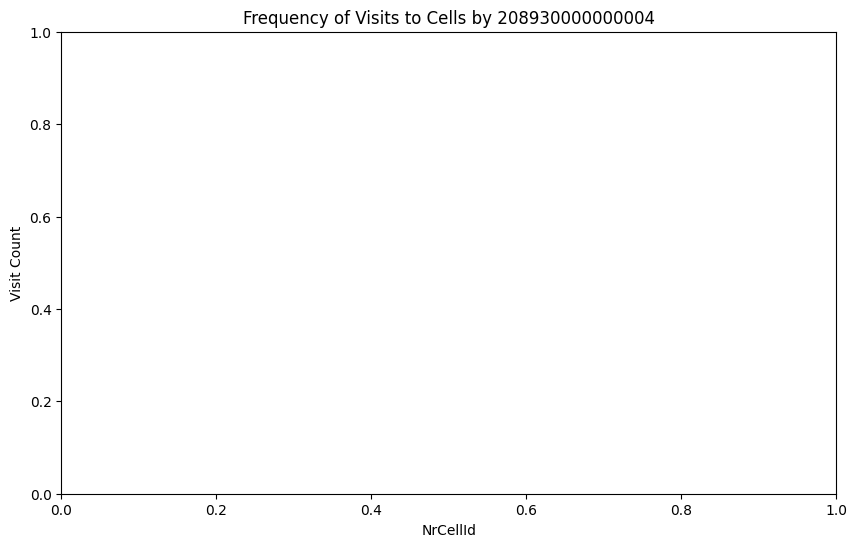

TypeError: int() takes at most 2 arguments (3 given)

In [ ]:
# Replace with the SUPI you want to track
target_supi = "208930000000004"

# Filter and sort the data for this SUPI
supi_history = df_location[df_location['supi'] == target_supi].sort_values('time')
supi_history = supi_history.reset_index(drop=True)

### Frequently Visited Cells

cell_counts = supi_history['NrCellId'].value_counts()
plt.figure(figsize=(10, 6))
# sns.barplot(x=cell_counts.index, y=cell_counts.values, palette="viridis")
sns.barplot(x=cell_counts.index, y=cell_counts.values, hue=cell_counts.index, palette="viridis", legend=False)
plt.title(f"Frequency of Visits to Cells by {target_supi}")
plt.xlabel("NrCellId")
plt.ylabel("Visit Count")
plt.show()


# Compute y-ticks as multiples of 10 based on the range of NrCellId
supi_history['NrCellId'] = pd.to_numeric(supi_history['NrCellId'], errors='coerce')
min_val = supi_history['NrCellId'].min()
max_val = supi_history['NrCellId'].max()
yticks = list(range((min_val // 10) * 10, ((max_val // 10) + 1) * 10, 10))

## 2. Temporal Analysis
### Activity Over Time
plt.figure(figsize=(12, 6))
supi_history.set_index('time')['NrCellId'].plot(marker='o', linestyle='-', color='g')
plt.title(f"Cell Transitions Over Time for {target_supi}")
plt.xlabel("Time")
plt.ylabel("NrCellId")
plt.yticks(yticks)  # Dynamically set y-axis ticks
plt.grid(True)
plt.show()

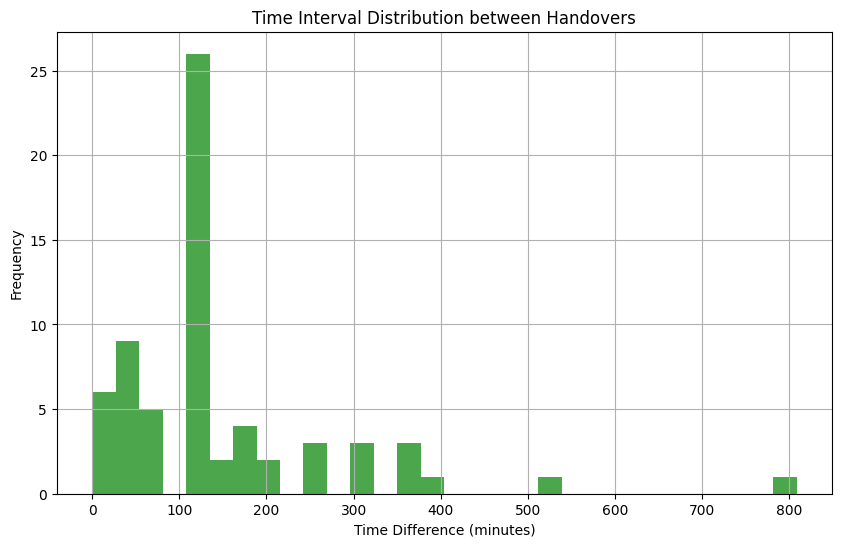

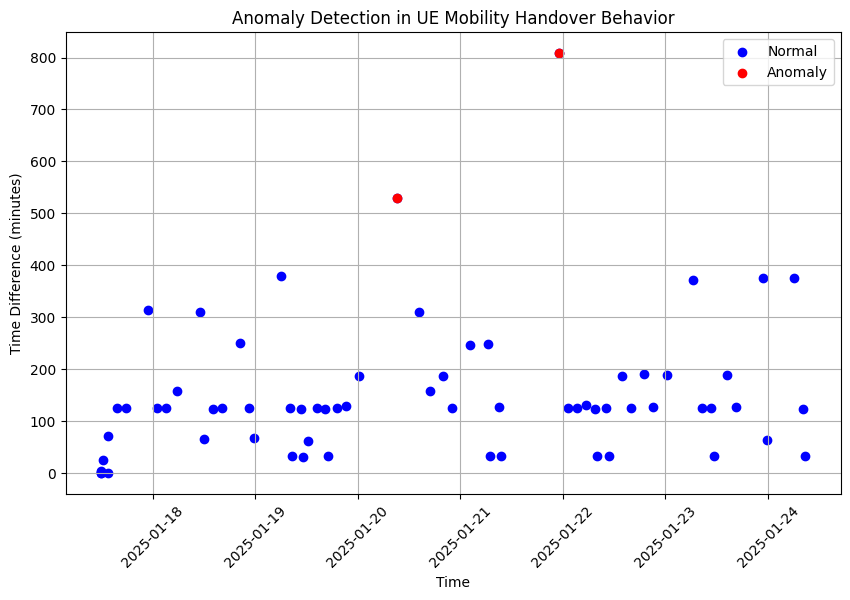

In [486]:

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# Calculate the time intervals between successive handovers
supi_history['time_diff'] = supi_history['time'].diff().dt.total_seconds()/60
supi_history.loc[0, "time_diff"] = 0.0

# Plot the distribution of time intervals
plt.figure(figsize=(10, 6))
plt.hist(supi_history['time_diff'].dropna(), bins=30, color='g', alpha=0.7)
plt.title('Time Interval Distribution between Handovers')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# --- 4. Anomaly Detection (Mobility Outliers) ---
# Use DBSCAN clustering for anomaly detection on time differences between handovers
scaler = StandardScaler()
time_diff_scaled = scaler.fit_transform(supi_history[['time_diff']].dropna())

dbscan = DBSCAN(eps=0.5, min_samples=5)
supi_history['anomaly'] = dbscan.fit_predict(time_diff_scaled)

# Plot the anomalies detected
anomalies = supi_history[supi_history['anomaly'] == -1]
plt.figure(figsize=(10, 6))
plt.scatter(supi_history['time'], supi_history['time_diff'], c='b', label='Normal')
plt.scatter(anomalies['time'], anomalies['time_diff'], c='r', label='Anomaly')
plt.title('Anomaly Detection in UE Mobility Handover Behavior')
plt.xlabel('Time')
plt.ylabel('Time Difference (minutes)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# # Display the anomalies (if any)
# anomalies[['time', 'time_diff']]


In [487]:
from statsmodels.tsa.arima.model import ARIMA

supi_history = supi_history.sort_values(by='time')

df_time_diff = supi_history['time_diff']
display(df_time_diff.tail())

# ARIMA for forecasting

# Fit an ARIMA model to the time differences between handovers
# (order=(p,d,q) will be tuned based on the data, using (5,1,0) as an example here)
model = ARIMA(df_time_diff, order=(5, 1, 0))  # p=5, d=1, q=0 as an example
model_fit = model.fit()

# Forecast the next 'n' time differences (e.g., forecast the next 10 handover intervals)
forecast_steps = 2
forecast = model_fit.forecast(steps=forecast_steps)


# Print forecasted time intervals for next handovers
print("Forecasted time to next handovers (in minutes):")
print(forecast)


61    376.025364
62     63.942246
63    375.942007
64    123.924528
65     33.888543
Name: time_diff, dtype: float64

Forecasted time to next handovers (in minutes):
66    158.258445
67    192.095060
Name: predicted_mean, dtype: float64


In [491]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preprocessing
def preprocess_data(supi_history):
    # Convert timestamp to datetime
    df = supi_history.copy()
    
    # Extract time-based features
    df['hour'] = df['time'].dt.hour
    df['day'] = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['month'] = df['time'].dt.month
    
    # Calculate time spent in each cell (dwell time)
    df['next_time'] = df['time'].shift(-1)
    df['dwell_time'] = (df['next_time'] - df['time']).dt.total_seconds() / 60  # in minutes
    
    # Create previous cell features
    df['prev_cell'] = df['NrCellId'].shift(1)
    # df['prev_tac'] = df['tac'].shift(1)
    return df

# 2. Feature Engineering
def create_features(df):
    # Calculate transition patterns
    df['next_cell'] = df['NrCellId'].shift(-1)
    
    # Create time windows
    df['time_window'] = pd.cut(df['hour'], 
                              bins=[0, 5, 11, 14, 17, 24], 
                              labels=['night', 'morning', 'lunch', 'afternoon', 'evening'])
    
    # Calculate cell visit frequency
    cell_freq = df['NrCellId'].value_counts(normalize=True).to_dict()
    df['cell_frequency'] = df['NrCellId'].map(cell_freq)
    
    # Calculate transition probabilities
    transitions = df.groupby('NrCellId')['next_cell'].value_counts(normalize=True).to_dict()
    df['transition_prob'] = df.apply(lambda x: transitions.get((x['NrCellId'], x['next_cell']), 0), axis=1)

    return df

# 3. Model Preparation
def prepare_model_data(df):
    # Remove rows with NaN values created by shifts
    df = df.dropna()
    
    # Encode categorical variables
    le = LabelEncoder()
    df['cell_encoded'] = le.fit_transform(df['NrCellId'])
    df['next_cell_encoded'] = le.transform(df['next_cell'])
    
    # Create feature matrix
    features = ['hour', 'weekday', 'cell_encoded', 'cell_frequency', 'transition_prob']
    X = df[features]
    y = df['next_cell_encoded']
    
    return X, y, le

# 4. Train Model
def train_mobility_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    return model, X_test, y_test

# 5. Evaluate Model
def evaluate_model(model, X_test, y_test, le):
    predictions = model.predict(X_test)
    
    # # Create confusion matrix
    # cm = confusion_matrix(y_test, predictions)
    
    # # Plot confusion matrix
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='d', 
    #             xticklabels=le.classes_,
    #             yticklabels=le.classes_)
    # plt.title('Confusion Matrix of Cell Predictions')
    # plt.xlabel('Predicted Cell')
    # plt.ylabel('Actual Cell')
    # plt.show()
    
    # Calculate accuracy
    accuracy = model.score(X_test, y_test)
    
    return accuracy

# 6. Forecast Future Movements
def forecast_next_moves(model, last_known_state, le, n_predictions=2):
    current_state = last_known_state.copy()
    predictions = []
    
    for _ in range(n_predictions):
        # Make prediction
        next_cell_encoded = model.predict([current_state])[0]
        next_cell = le.inverse_transform([next_cell_encoded])[0]
        predictions.append(next_cell)
        
        # Update state for next prediction
        current_state['cell_encoded'] = next_cell_encoded
        current_state['hour'] = (current_state['hour'] + 1) % 24
        
    return predictions

# Main execution
def main(supi_history):
    # Preprocess data
    df = preprocess_data(supi_history)
    
    # Create features
    df = create_features(df)
    
    # Prepare data for model
    X, y, le = prepare_model_data(df)
    
    # Train model
    model, X_test, y_test = train_mobility_model(X, y)
    
    # Evaluate model
    accuracy = evaluate_model(model, X_test, y_test, le)
    print(f"Model Accuracy: {accuracy:.2f}")

    # Make future predictions
    last_state = X.iloc[-1]
    future_cells = forecast_next_moves(model, last_state, le)
    
    print("\nPredicted next cell sequence:")
    for i, cell in enumerate(future_cells, 1):
        print(f"t+{i}: {cell}")
    
    return model, le, df

# Execute the analysis
model, le, processed_df = main(supi_history)

Model Accuracy: 0.95

Predicted next cell sequence:
t+1: 30
t+2: 30
